In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels as sm
import seaborn as sns

sns.set_theme(style="whitegrid")

In [2]:
df = pd.read_csv('train.csv')
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [3]:
df['GroupId'] = df['PassengerId'].str.extract(r'^(\d{4})')

In [4]:
df[['Deck', 'Num', 'Side']] = df['Cabin'].str.extract(r'^(\w)/(\d+)/(\w)$')
df['Deck'] = df['Deck'].fillna('0')
df['Num'] = df['Num'].fillna('0').astype(int)
df['Side'] = df['Side'].fillna(df['Side'].mode())
df['RoomMates'] = df.groupby('Cabin')['Cabin'].transform('count').fillna(0).astype(int)

In [5]:
df['HomePlanet'] = df.groupby('GroupId')['HomePlanet'].bfill()
df['HomePlanet'] = df.groupby('GroupId')['HomePlanet'].ffill()

In [6]:
from sklearn.preprocessing import LabelEncoder

planet_encoder = LabelEncoder()
dest_encoder = LabelEncoder()
deck_encoder = LabelEncoder()
side_encoder = LabelEncoder()
df['HomePlanet'] = planet_encoder.fit_transform(df['HomePlanet'].fillna(df['HomePlanet'].mode()[0]))
df['CryoSleep'] = df['CryoSleep'].fillna(df['CryoSleep'].mode()[0]).astype(int)
df['Destination'] = dest_encoder.fit_transform(df['Destination'].fillna(df['Destination'].mode()[0]))
df['VIP'] = df['VIP'].fillna(df['VIP'].mode()[0]).astype(int)
df['Deck'] = deck_encoder.fit_transform(df['Deck'])
df['Side'] = side_encoder.fit_transform(df['Side'])
if 'Transported' in df.columns:
    df['Transported'] = df['Transported'].fillna(df['Transported'].mode()[0]).astype(int)

In [7]:
df['Age'] = df['Age'].fillna(df['Age'].mean()).astype(int)
df['AgeRange'] = pd.cut(df['Age'], bins=[0, 20, 50, 100], include_lowest=True, labels=[0, 1, 2])

In [8]:
df['FamilySize'] = df['PassengerId'].str.extract(r'^(\d{4})').groupby(0)[0].transform('count')

In [9]:
df['RoomService'] = np.log10(df['RoomService'].fillna(0) + 1)
df['FoodCourt'] = np.log10(df['FoodCourt'].fillna(0) + 1)
df['ShoppingMall'] = np.log10(df['ShoppingMall'].fillna(0) + 1)
df['Spa'] = np.log10(df['Spa'].fillna(0) + 1)
df['VRDeck'] = np.log10(df['VRDeck'].fillna(0) + 1)
df['Expenses'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

In [10]:
from sklearn.model_selection import train_test_split

dff = df.drop(columns=[
    'PassengerId',
    'GroupId',
    'Cabin',
    # 'Age',
    'Name',
    # 'RoomService',
    # 'FoodCourt',
    # 'ShoppingMall',
    # 'Spa',
    # 'VRDeck'
    # 'VIP',
    # 'Destination',
    # 'RoomMates',
    # 'AgeRange',
    # 'FamilySize',
    # 'Deck',
    # 'Side',
])
df_train, df_test = train_test_split(dff, test_size=.2, shuffle=True)
X_train_df = df_train.drop(columns=['Transported'])
y_train_df = df_train[['Transported']]
X_test_df = df_test.drop(columns=['Transported'])
y_test_df = df_test[['Transported']]

In [11]:
X_train_df.dtypes

HomePlanet         int64
CryoSleep          int64
Destination        int64
Age                int64
VIP                int64
RoomService      float64
FoodCourt        float64
ShoppingMall     float64
Spa              float64
VRDeck           float64
Deck               int64
Num                int64
Side               int64
RoomMates          int64
AgeRange        category
FamilySize         int64
Expenses         float64
dtype: object

In [196]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

ada = AdaBoostClassifier(RandomForestClassifier())
ada.fit(X_train_df, y_train_df)
ada.score(X_test_df, y_test_df)

/home/stark/miniconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7809085681426107

In [193]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_jobs=-1)
xgb.fit(X_train_df, y_train_df)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [194]:
xgb.score(X_test_df, y_test_df)

0.7998849913743531

In [12]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(max_depth=100, n_estimators=200, n_jobs=-1)
forest.fit(X_train_df, y_train_df)

/tmp/ipykernel_26012/1469158173.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train_df, y_train_df)


RandomForestClassifier(max_depth=100, n_estimators=200, n_jobs=-1)

In [13]:
forest.score(X_test_df, y_test_df)

0.8188614146060954

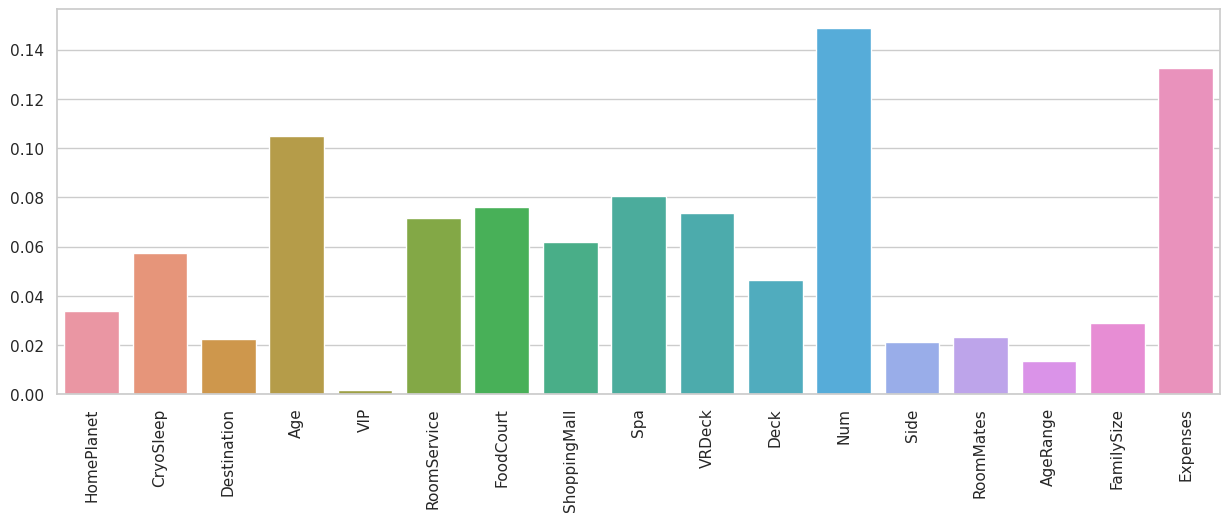

In [14]:
feature_importance = pd.DataFrame(forest.feature_importances_.reshape(1, -1), columns=X_train_df.columns)
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(feature_importance, ax=ax)
ax.tick_params(axis='x', rotation=90)
plt.show()

In [171]:
dff = df.drop(columns=[
    'PassengerId',
    'Cabin',
    # 'Age',
    'Name',
    # 'RoomService',
    # 'FoodCourt',
    # 'ShoppingMall',
    # 'Spa',
    # 'VRDeck'
    'VIP',
    'Destination',
    'RoomMates',
    'AgeRange',
    'FamilySize',
    'Deck',
    'Side',
])
predictions = forest.predict(dff)
predictions

array([1, 0, 1, ..., 1, 1, 0])

In [175]:
out = pd.DataFrame({'Transported': predictions.astype(bool)}, index=df.PassengerId)
out

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,False
...,...
9266_02,False
9269_01,False
9271_01,True


In [176]:
out.to_csv('submission.csv')